In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import cobra
import cobra.test
from cobra.test import create_test_model
from cobra.util.solver import linear_reaction_coefficients
from cobra.flux_analysis import flux_variability_analysis
from cobra.sampling import sample

import cobrapy_func as cf

import time
import tqdm

In [2]:
# Load zbgem2 model
t0 = time.time()
fn_zgem2 = "/Users/don/Documents/mlardelli/data/zebragem_20200228_mod.xml"
model = cobra.io.read_sbml_model(fn_zgem2)
print("Loaded SBML file in %.2fs" % (time.time() - t0))

# Print stuff out
print(f"num reactions = {len(model.reactions)}")
print(f"num metabs = {len(model.metabolites)}")
print(f"num genes = {len(model.genes)}")
print(f"num exchanges = {len(model.exchanges)}")
print("")
model.objective ="BIO_L_2"

# Load DE genes
d0 = pd.read_csv("/Users/don/Documents/mlardelli/data/de_genes.csv")

# For the genes in the DE list, get only those which are in ZBGEM
zbgem_gene_ls = [g.id for g in model.genes]

de_genes_ls = []
for ncbi_id in list(d0["ncbi_id"]):
    if ncbi_id in zbgem_gene_ls:
        de_genes_ls.append(ncbi_id)
print(f"Num. DE genes present in ZBGEM = {len(de_genes_ls)}")

de_df = d0.loc[d0["ncbi_id"].isin(de_genes_ls)]

# Get dict of reactions affected by DE genes, and a flat list
rxn_dict = {}
affected_rxn_ls = []
for ncbi_id in de_genes_ls:
    val_ls = [rxn.id for rxn in list(model.genes.get_by_id(ncbi_id).reactions)]
    rxn_dict[ncbi_id] = val_ls
    affected_rxn_ls.append(val_ls)

affected_rxn_ls = list(set([item for sublist in affected_rxn_ls for item in sublist]))

# Get affected reactions AFTER checking GPR, regardless of fold change direction
affected_rxn_ls2 = []
for rxn_id in affected_rxn_ls:
    rxn = model.reactions.get_by_id(rxn_id)
    gpr_str = rxn.gene_reaction_rule
    
    eval_bool = cf.eval_gpr(gpr_str, de_genes_ls)
    if eval_bool:
        affected_rxn_ls2.append(rxn_id)

print(f"{len(affected_rxn_ls2)} reactions impacted by DE genes")

Loaded SBML file in 4.28s
num reactions = 3023
num metabs = 2810
num genes = 1636
num exchanges = 44

Num. DE genes present in ZBGEM = 28
28 reactions impacted by DE genes


In [6]:
model.compartments

{'environment': 'environment',
 'golgi': 'Golgi apparatus lumen',
 'cytosol': 'cytoplasm',
 'endoplasmicreticulum': 'endoplasmic reticulum lumen',
 'extracellular': 'extracellular space',
 'lysosome': 'lysosomal lumen',
 'mitochondria': 'mitochondrial matrix',
 'mitochondrialintermembranespace': 'mitochondrial intermembrane space',
 'nucleus': 'nucleoplasm',
 'peroxisome': 'peroxisomal matrix',
 'membrane': 'membrane',
 'mitochondrialinnermembrane': 'mitochondrial inner membrane',
 'endoplasmicreticulummembrane': 'endoplasmic reticulum membrane'}

In [3]:
# Get exact solutions
soln = model.optimize()

In [4]:
# Get flux samples
model = cobra.io.read_sbml_model(fn_zgem2)
model.objective ="BIO_L_2"
n_samples = 100000
t0 = time.time()
df_flux_samples = sample(model, n_samples, method="achr")

print("Done in %.2fs" % (time.time() - t0))

Done in 3972.66s


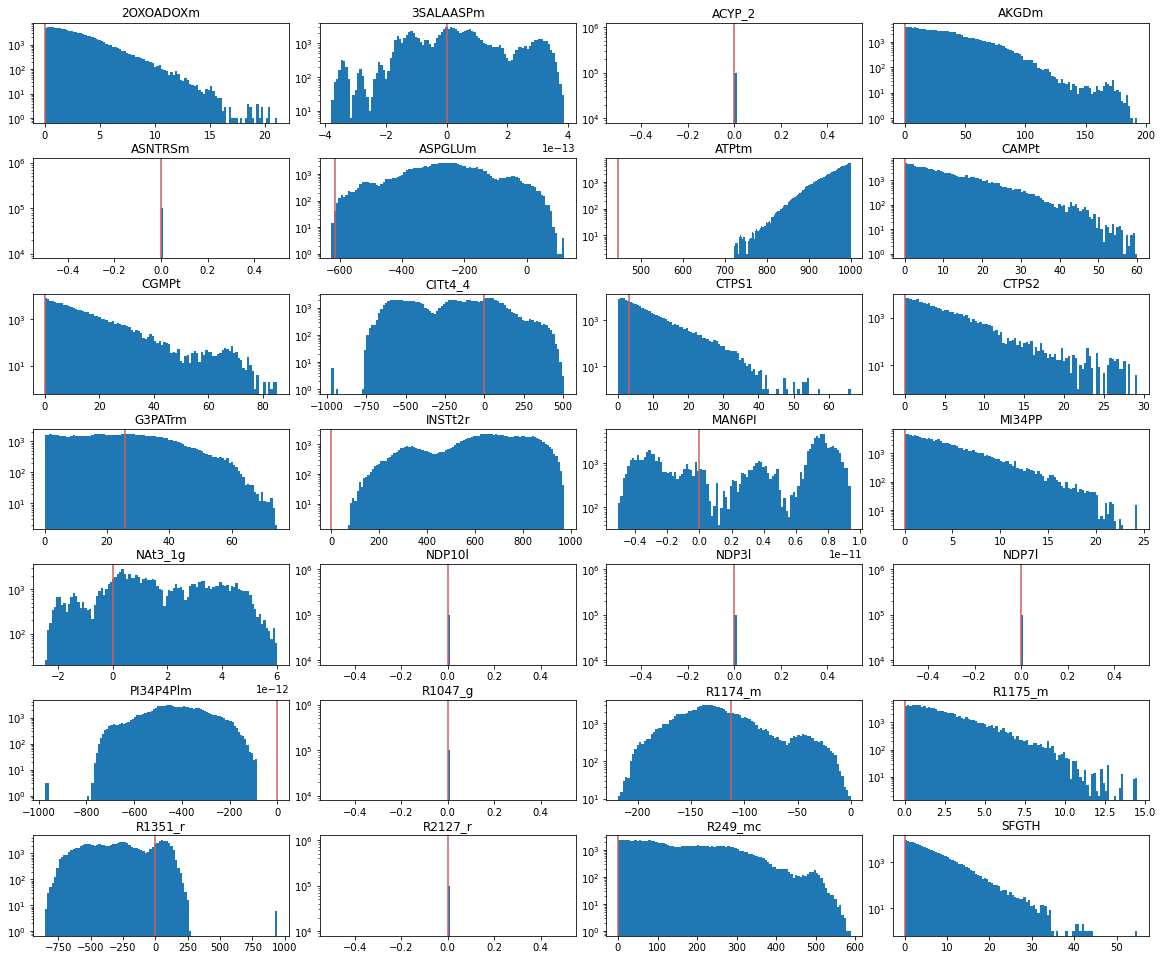

<Figure size 432x288 with 0 Axes>

In [5]:
# plot flux samples
num_rows = 7
num_cols = 4
affected_rxn_ls2.sort()

fig, axarr = plt.subplots(num_rows, num_cols, figsize=(20, 2.4*num_rows))

idx = 0
for i in np.arange(num_rows):
    for j in np.arange(num_cols):
        arr = list(df_flux_samples[affected_rxn_ls2[idx]])
        flux_opt_soln = soln[affected_rxn_ls2[idx]]
        
        axarr[i, j].hist(arr, bins=100)
        axarr[i, j].set_yscale('log')
        axarr[i, j].set_title(affected_rxn_ls2[idx])
        axarr[i, j].axvline(x=flux_opt_soln, c="indianred")
        
        idx +=1

fig.subplots_adjust(wspace=0.12, hspace=0.35)
plt.show()

plt.savefig("/Users/don/Documents/mlardelli/plots/zbgem2-flux-samples-100k.pdf", bboxinches="tight")

In [ ]:
plt.hist(df_flux_samples["BIO_L_2"], bins=100)
plt.title("ZBgem2.0 BIO_L_2 distro, 100k flux samples")

plt.savefig("/Users/don/Documents/mlardelli/plots/zbgem2-bio_l_2-100k.pdf", bboxinches="tight")

plt.show()